In [1]:
# PyTorch and PyTorch Geometric imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import torch_geometric.utils as pyg_utils
from torch_geometric.utils import from_networkx

# NetworkX imports
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# Other imports
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import random

# Custom imports
from Datasets.synthetics import BA_2grid, BA_2grid_house, ProbingDataset, BA_2grid_to_test
from models.models_BA_2grid import GIN_framework as framework

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    if seed == -1:
        seed = random.randint(0, 1000)
    # Pandas also uses np random state by default
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
set_seed(37)

Model

In [5]:
MODEL = "GCN"
DATASET = "BA_2grid_house"

# import the model
from models.models_BA_2grid_house import GCN_framework as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house

In [6]:
# inizialize the framework
dataset = BA_2grid_house()
gnn = framework(dataset,device="cpu")

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [62]:
#dataset length
len(dataset)

2000

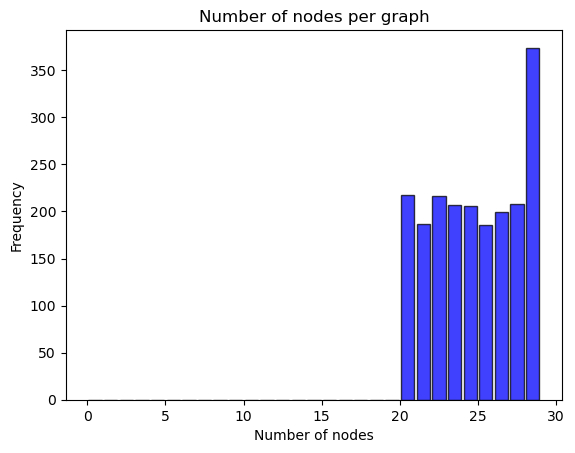

(20, 29)

In [84]:
#pritn the distribution of the number of nodes per graph in the dataset

# number of nodes per graph
nodes = [len(graph.x) for graph in dataset]
plt.hist(nodes, bins=range(0, max(nodes)+1, 1), alpha=0.75, rwidth=0.85, color='b', edgecolor='black')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.title('Number of nodes per graph')
plt.show()

#print the min and max number of nodes in the dataset
min(nodes), max(nodes)

In [69]:
#number of nodes of the first graph 
len(dataset[0].x)

29

In [14]:
# the gnn object contains the train test split and the model.

print(gnn.model)
print(gnn.train_idx)
print(gnn.dataset[gnn.train_idx])

Net(
  (conv1): GCNConv(10, 60)
  (conv2): GCNConv(60, 60)
  (conv3): GCNConv(60, 60)
  (conv4): GCNConv(60, 60)
  (lin1): Linear(in_features=60, out_features=60, bias=True)
  (lin2): Linear(in_features=60, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=2, bias=True)
)
tensor([ 701, 1225,   47,  ...,   40,  423,  494])
BA_2grid_house(1600)


In [7]:
#now that the model is instaziated, we have to load the weights
gnn.load_model("models/"+DATASET+"_"+MODEL)
print("we loaded the weights")
# right now the model has trained weights.
#print(gnn.model.mlp1.weight[0])

we loaded the weights


In [8]:
# train the model
gnn.evaluate()

Test Loss: 0.029, Train Acc: 0.971 Test Acc: 0.965


In [ ]:
def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_nodes_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_nodes_in_the_largest_fully_connected_component, small_world))
    return properties

train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

In [13]:
print(train_properties[0:3])
print(test_properties[0:3])

[(25, 30, 0.1, 4.086666666666667, 28, 1.0, 0.8232142857142858, 25, 0.8109891739581787), (27, 32, 0.09116809116809117, 4.626780626780627, 30, 1.0, 0.8051587301587302, 27, 0.6486555829228241), (27, 32, 0.09116809116809117, 4.347578347578348, 30, 1.0, 0.7524891774891775, 27, 0.4754987621960099)]
[(26, 31, 0.09538461538461539, 4.541538461538462, 29, 1.0, 0.7575396825396825, 26, 1.3489159891598916), (26, 31, 0.09538461538461539, 4.406153846153846, 29, 1.0, 0.8107142857142858, 26, 0.9419615145872129), (27, 28, 0.07977207977207977, 3.561253561253561, 26, 1.0, 0.2648809523809524, 27, 0.9992)]


In [27]:
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties_special.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties_special.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

In [56]:
#open the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_special.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_special.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [57]:
len(test_properties)

400

### Probing pipeline 

from extracting features to training a diagnostic classifier

In [9]:
train_features, test_features = gnn.evaluate_with_features2()

x1 shape: torch.Size([25, 60])
x2 shape: torch.Size([25, 60])
x3 shape: torch.Size([25, 60])
x4 shape: torch.Size([25, 60])
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
x1 shape: torch.Size([25, 60])
x2 shape: torch.Size([25, 60])
x3 shape: torch.Size([25, 60])
x4 shape: torch.Size([25, 60])
x1 shape: torch.Size([29, 60])
x2 shape: torch.Size([29, 60])
x3 shape: torch.Size([29, 60])
x4 shape: torch.Size([29, 60])
x1 shape: torch.Size([29, 60])
x2 shape: torch.Size([29, 60])
x3 shape: torch.Size([29, 60])
x4 shape: torch.Size([29, 60])
x1 shape: torch.Size([24, 60])
x2 shape: torch.Size([24, 60])
x3 shape: torch.Size([24, 60])
x4 shape: torch.Size([24, 60])
x1 shape: torch.Size([24, 60])
x2 shape: torch.Size([24, 60])
x3 shape: torch.Size([24, 60])
x4 shape: torch.Size([24, 60])
x1 shape

In [10]:
len(train_features), len(test_features)

(1600, 400)

In [11]:
len(train_features[0])

8

##### Testes of different posibilities

In [19]:
#check if the gnn.dataset[gnn.train_idx] is the same as the one in the dataset to check if the split is reproducible

# let's create the train and test loaders from dataset
idx = torch.arange(len(dataset))
train_idx, test_idx = train_test_split(idx, train_size=0.8, stratify=dataset.data.y,random_state=10)

train_loader = DataLoader(dataset[train_idx],batch_size=256)
test_loader = DataLoader(dataset[test_idx],batch_size=256)

# let's check if the loaders are the same as the one in the gnn object
for i, (data) in enumerate(train_loader):
    print(data)
    print(gnn.dataset[gnn.train_idx[i]])
    if i == 3: 
        break


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


DataBatch(x=[6282, 10], edge_index=[2, 14448], edge_attr=[14448], y=[256], expl_mask=[6282], batch=[6282], ptr=[257])
Data(x=[25, 10], edge_index=[2, 60], edge_attr=[60], y=[1], expl_mask=[25])
DataBatch(x=[6271, 10], edge_index=[2, 14330], edge_attr=[14330], y=[256], expl_mask=[6271], batch=[6271], ptr=[257])
Data(x=[27, 10], edge_index=[2, 64], edge_attr=[64], y=[1], expl_mask=[27])
DataBatch(x=[6252, 10], edge_index=[2, 14196], edge_attr=[14196], y=[256], expl_mask=[6252], batch=[6252], ptr=[257])
Data(x=[27, 10], edge_index=[2, 64], edge_attr=[64], y=[1], expl_mask=[27])
DataBatch(x=[6188, 10], edge_index=[2, 14140], edge_attr=[14140], y=[256], expl_mask=[6188], batch=[6188], ptr=[257])
Data(x=[25, 10], edge_index=[2, 60], edge_attr=[60], y=[1], expl_mask=[25])


In [25]:
# save gnn.dataset[gnn.train_idx] and gnn.dataset[gnn.test_idx] in a file
with open("models/"+DATASET+"_"+MODEL+"_train.pkl", "wb") as f:
    pkl.dump(gnn.dataset[gnn.train_idx], f)

with open("models/"+DATASET+"_"+MODEL+"_test.pkl", "wb") as f:
    pkl.dump(gnn.dataset[gnn.test_idx], f)

In [20]:
# load the data
with open("models/"+DATASET+"_"+MODEL+"_train.pkl", "rb") as f:
    train_data = pkl.load(f)

In [43]:
# Evaluate to get features
train_features, test_features = gnn.evaluate_with_features2()

# Extract x_global and x_lin1 embeddings for training set
train_x_global = np.array([feat[0] for feat in train_features])
train_x_lin1 = np.array([feat[1] for feat in train_features])

#take only the first 10 elements
# train_x_global = train_x_global[:10]
# train_x_lin1 = train_x_lin1[:10]

# Extract x_global and x_lin1 embeddings for test set
test_x_global = np.array([feat[0] for feat in test_features])
test_x_lin1 = np.array([feat[1] for feat in test_features])

#take only the first 10 elements
# test_x_global = test_x_global[:10]
# test_x_lin1 = test_x_lin1[:10]


In [44]:
#print the number of embeddings for the train and test set
print(len(train_x_global), len(train_x_lin1), len(test_x_global), len(test_x_lin1))

1600 1600 400 400


linear regression

In [ ]:
import numpy as np

# Prepare training data
train_x = train_x_global  # or use train_x_lin1 if you prefer
train_y = np.array(train_properties)

# Prepare testing data
test_x = test_x_global  # or use test_x_lin1 if you prefer
test_y = np.array(test_properties)


In [ ]:
# Train a regression model for each graph property
models = []
for i in range(train_y.shape[1]):
    model = LinearRegression()
    model.fit(train_x, train_y[:, i])
    models.append(model)

# Evaluate the models
for i, model in enumerate(models):
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)
    
    train_mse = mean_squared_error(train_y[:, i], train_pred)
    test_mse = mean_squared_error(test_y[:, i], test_pred)
    
    print(f'Property {i}: Train MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}')


Linear model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)


In [20]:
# Convert to PyTorch tensors
train_x = torch.tensor(train_x_global, dtype=torch.float32)
train_y = torch.tensor(train_properties, dtype=torch.float32)

test_x = torch.tensor(test_x_global, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)


In [21]:
len(train_x)

1600

In [22]:
train_y[:, 4]

tensor([28., 30., 30.,  ..., 26., 29., 22.])

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features()

# Extract x_global embeddings
train_x_global = np.array([feat[0] for feat in train_features])
test_x_global = np.array([feat[0] for feat in test_features])

# Extract 5th, 6th and 7th embeddings
train_x5 = np.array([feat[1] for feat in train_features])
test_x5 = np.array([feat[1] for feat in test_features])

train_x6 = np.array([feat[2] for feat in train_features])
test_x6 = np.array([feat[2] for feat in test_features])

train_x7 = np.array([feat[3] for feat in train_features])
test_x7 = np.array([feat[3] for feat in test_features])

# Compute graph properties
train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x_global, dtype=torch.float32)
train_y = torch.tensor(train_properties, dtype=torch.float32)

test_x = torch.tensor(test_x_global, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)



# Train and evaluate a model for each graph property and each embeddings
input_size = train_x.shape[1]
output_size = 1  # Predicting one property at a time

property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques']
""" 
for i, property_name in enumerate(property_names):
    model = LinearModel(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10000

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(train_x).squeeze()  # Ensure outputs is the correct shape
        target = train_y[:, i].squeeze()  # Ensure target is the correct shape

        # Debugging information
        #print(f"Epoch [{epoch+1}/{num_epochs}], Property: {property_name}")
        #print(f"outputs shape: {outputs.shape}, target shape: {target.shape}")

        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_pred = model(train_x).squeeze().cpu().numpy()
        test_pred = model(test_x).squeeze().cpu().numpy()
        
        train_target = train_y[:, i].cpu().numpy()
        test_target = test_y[:, i].cpu().numpy()
        
        train_mse = mean_squared_error(train_target, train_pred)
        test_mse = mean_squared_error(test_target, test_pred)
        
        train_r2 = r2_score(train_target, train_pred)
        test_r2 = r2_score(test_target, test_pred)
        
        print(f'Property: {property_name}')
        print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
        print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}') """

# Train and evaluate a model for each graph property and each embeddings
input_size = train_x.shape[1]
output_size = 1  # Predicting one property at a time

property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']

embeddings = [train_x, train_x5, train_x6, train_x7]

for embedding in embeddings:
    # Train and evaluate a model for each graph property
    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(embedding).squeeze().cpu().numpy()
            test_pred = model(test_x).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {embedding}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')


Epoch [1000/10000], Loss: 237.0360
Epoch [2000/10000], Loss: 71.4868
Epoch [3000/10000], Loss: 18.9631
Epoch [4000/10000], Loss: 10.2091
Epoch [5000/10000], Loss: 9.3161
Epoch [6000/10000], Loss: 8.6447
Epoch [7000/10000], Loss: 7.8577
Epoch [8000/10000], Loss: 7.0829
Epoch [9000/10000], Loss: 6.4805
Epoch [10000/10000], Loss: 6.1348
Embedding: tensor([[0.2183, 0.0000, 0.4611,  ..., 0.0000, 0.1694, 0.0556],
        [0.3875, 0.0691, 0.5461,  ..., 0.0000, 0.2936, 0.1324],
        [0.3057, 0.0416, 0.5032,  ..., 0.0000, 0.2335, 0.1090],
        ...,
        [0.3618, 0.0650, 0.5324,  ..., 0.0000, 0.2764, 0.1351],
        [0.1982, 0.0000, 0.4815,  ..., 0.0000, 0.1522, 0.0424],
        [0.2208, 0.0012, 0.4946,  ..., 0.0000, 0.1699, 0.0512]])
Property: num_nodes
  Train MSE: 6.1346, Test MSE: 6.3851
  Train R²: 0.2572, Test R²: 0.2066
Epoch [1000/10000], Loss: 348.2207
Epoch [2000/10000], Loss: 128.6861
Epoch [3000/10000], Loss: 42.0815
Epoch [4000/10000], Loss: 20.5685
Epoch [5000/10000], Los

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1600x10 and 60x1)

### Diagnostic classifier

In [28]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x_global, x5, x6, x7)
"""

output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x_global = np.array([feat[4] for feat in train_features])
test_x_global = np.array([feat[4] for feat in test_features])

train_x5 = np.array([feat[5] for feat in train_features])
test_x5 = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']

#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save the results in a file
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/10000], Property: num_nodes, Loss: 488.7543
Epoch [2000/10000], Property: num_nodes, Loss: 391.5803
Epoch [3000/10000], Property: num_nodes, Loss: 308.8561
Epoch [4000/10000], Property: num_nodes, Loss: 239.0096
Epoch [5000/10000], Property: num_nodes, Loss: 180.9966
Epoch [6000/10000], Property: num_nodes, Loss: 134.0242
Epoch [7000/10000], Property: num_nodes, Loss: 97.3020
Epoch [8000/10000], Property: num_nodes, Loss: 69.8417
Epoch [9000/10000], Property: num_nodes, Loss: 50.3697
Epoch [10000/10000], Property: num_nodes, Loss: 37.0393
Embedding: torch.Size([1600, 60])
Property: num_nodes
  Train MSE: 37.0284, Test MSE: 35.0007
  Train R²: -3.4836, Test R²: -3.3491
Epoch [1000/10000], Property: num_edges, Loss: 657.7014
Epoch [2000/10000], Property: num_edges, Loss: 542.8296
Epoch [3000/10000], Property: num_edges, Loss: 442.6699
Epoch [4000/10000], Property: num_edges, Loss: 355.7265
Epoch [5000/10000], Property: num_edges, Loss: 281.0447
Epoch [6000/10000], Property: n

In [29]:
#load the results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

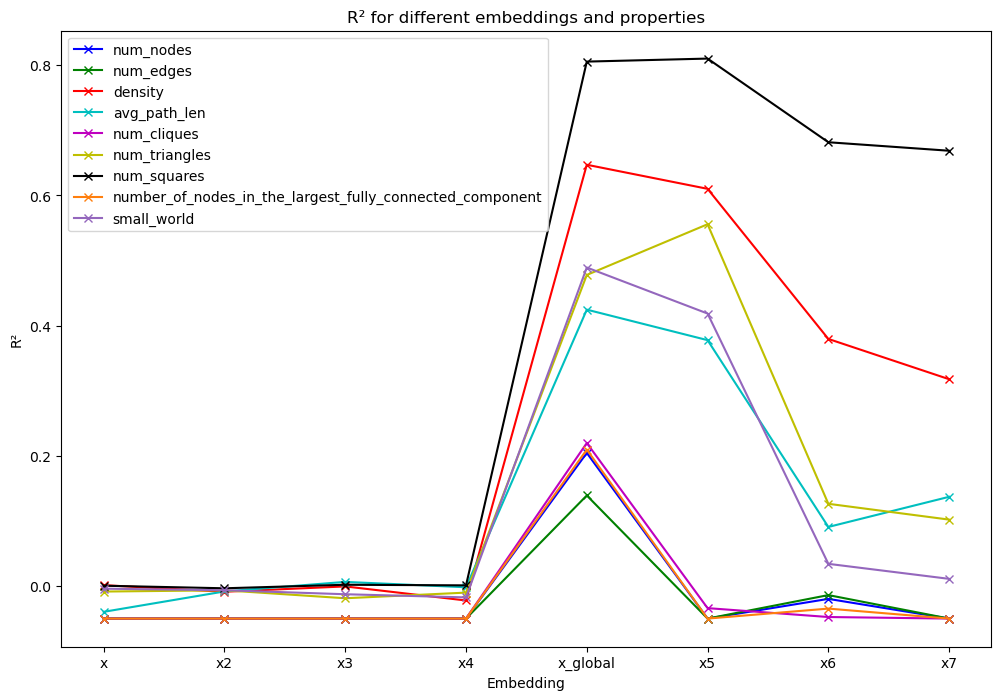

In [31]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
plt.show()


### Node embedding probing

This time we will try to probe for node embedding learnt representations. What would make sense is that the GNN uses some node characteristics like the betweeness centrality of some nodes to predict if a graph could contain both a grid and a house. 

In [13]:
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
test_node_properties = compute_node_properties(gnn.dataset[gnn.test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [14]:
len(train_node_properties), len(test_node_properties)

(1600, 400)

([6, 3, 1, 3, 1, 2, 1, 1, 1, 2, 2, 3, 1, 3, 2, 3, 3, 2, 3, 3, 2, 4, 3, 2, 3, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0.3333333333333333, 1.0, 0, 0, 0, 0, 0, 0, 0, 0], [0.5333333333333333, 0.15666666666666668, 0.0, 0.68, 0.0, 0.08, 0.0, 0.0, 0.0, 0.48000000000000004, 0.33333333333333337, 0.45777777777777784, 0.0, 0.2816666666666667, 0.03666666666666667, 0.11, 0.005, 0.0, 0.18666666666666665, 0.18666666666666665, 0.03277777777777778, 0.1488888888888889, 0.045000000000000005, 0.03277777777777778, 0.045000000000000005, 0.0044444444444444444], [0.10521234016833964, 0.048588000626310864, 0.03673891466296968, 0.1006609369854998, 0.03673891466296968, 0.041840717455278266, 0.03673891466296968, 0.016966456417454732, 0.016966456417454732, 0.13788238057672458, 0.04518201359998669, 0.29421941246853595, 0.014610350065082807, 0.028731959419011167, 0.016198792919026577, 0.020900550098289828, 0.017656811386470742, 0.013464259755574791, 0.3523681982355651, 0.352368198235565

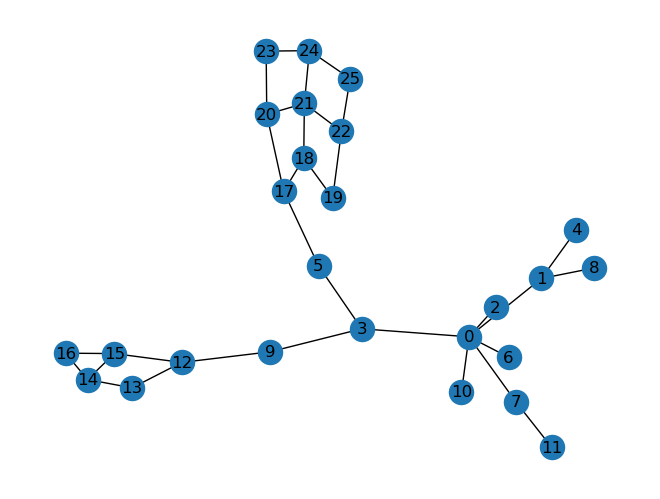

In [39]:
#visualise the first graph of the test set to see if the properties are correct
G = nx.from_edgelist(gnn.dataset[gnn.test_idx][0].edge_index.t().tolist())
nx.draw(G, with_labels=True)

#print the properties of the first graph
print(test_node_properties[0])

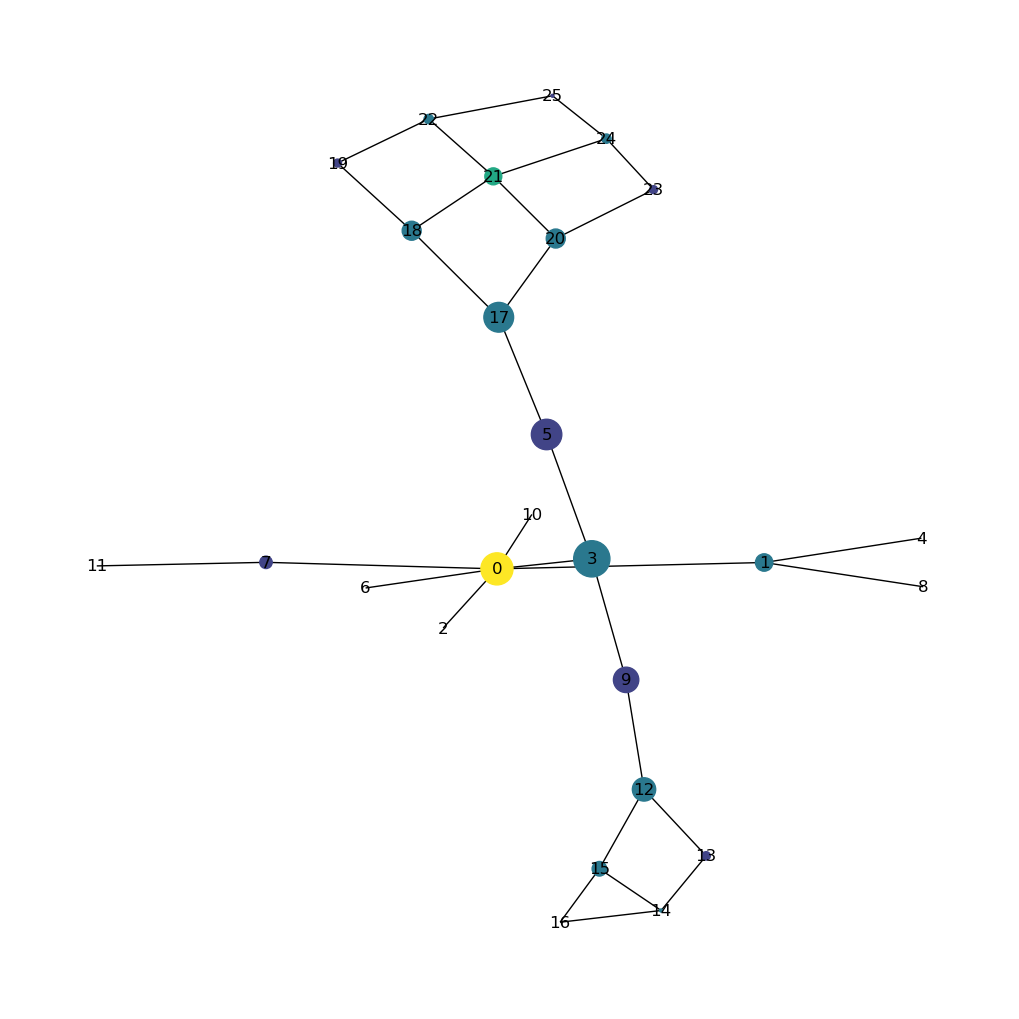

In [36]:
#represent the properties of betweenness centrality on the graph by chaging the size of the nodes
betweenness_centrality = test_node_properties[0][2]
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in betweenness_centrality], node_color=node_degrees, cmap='viridis')
plt.show()


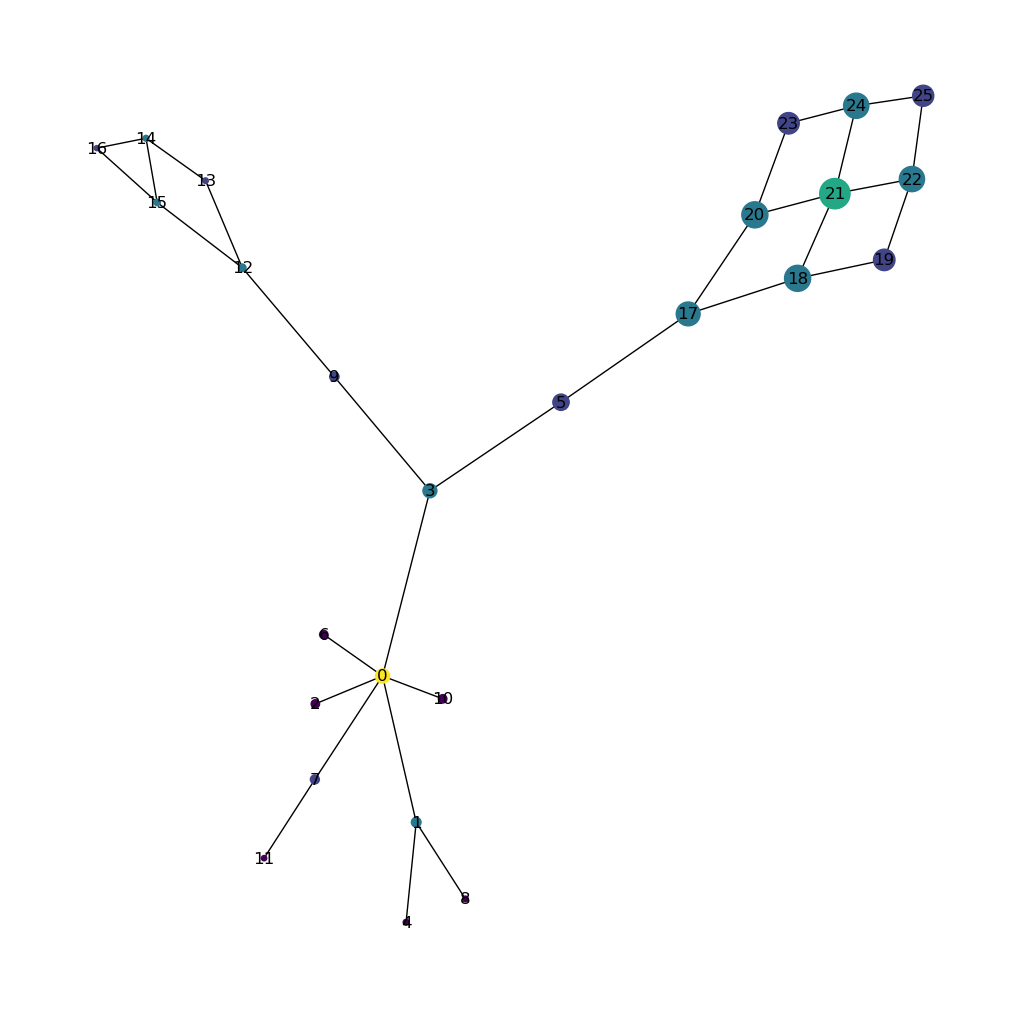

In [40]:
#same for eigenvector centrality
eigenvector_centralities = test_node_properties[0][3]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in eigenvector_centralities], node_color=node_degrees, cmap='viridis')
plt.show()

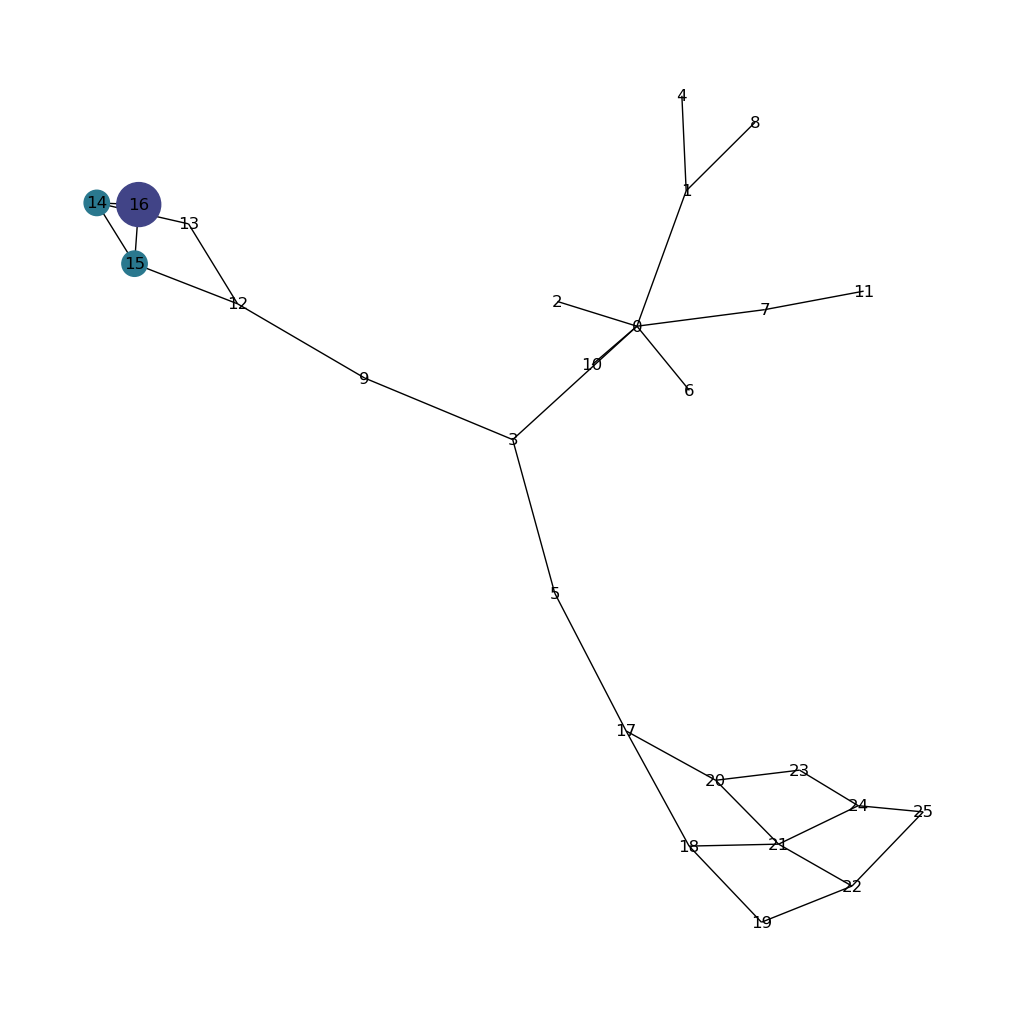

In [42]:
#same for local clustering coefficients
Local_clustering_coefficients = test_node_properties[0][4]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in Local_clustering_coefficients], node_color=node_degrees, cmap='viridis')
plt.show()

Hypothesis : it would make a lot of sense for the GNN to use both the node propeties of local clustering coefficient and eigenvector centrality. The interesting thing is that these two features individually are not enough to render he problem linearly separable. It would thus make sense to use both of these properties and combine them. At the end, the problem makes more sense to be solved in a global property fashion with the number of squares. 

Test avec concatenate

In [95]:
train_x2.shape

torch.Size([1600, 60])

In [96]:
# Concatenate properties with embeddings
def concatenate_embeddings_with_properties(node_embeddings, node_properties):
    concatenated_features = []
    for embeddings, properties in zip(node_embeddings, node_properties):
        combined = [np.concatenate((embedding, np.array(property))) for embedding, property in zip(embeddings, zip(*properties))]
        concatenated_features.append(combined)
    return concatenated_features

train_combined_features = concatenate_embeddings_with_properties(train_x2, train_node_properties)
test_combined_features = concatenate_embeddings_with_properties(test_x2, test_node_properties)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_18216\1439016593.py", line 9, in <module>
    train_combined_features = concatenate_embeddings_with_properties(train_x2, train_node_properties)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_18216\1439016593.py", line 5, in concatenate_embeddings_with_properties
    combined = [np.concatenate((embedding, np.array(property))) for embedding, property in zip(embeddings, zip(*properties))]
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_18216\1439016593.py", line 5, in <listcomp>
    combined = [np.concatenate((embedding, np.array(property))) for embedding, property in zip(embeddings, zip(*properties))]
ValueError: zero-dimensional arrays cannot be concatenated

During handling of the above exception, another exception occurred:

Trac

#### Diagnostic classifier

In [51]:
# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x_global = np.array([feat[4] for feat in train_features])
test_x_global = np.array([feat[4] for feat in test_features])

train_x5 = np.array([feat[5] for feat in train_features])
test_x5 = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

# train_y_node = torch.tensor(train_node_properties, dtype=torch.float32)
# test_y_node = torch.tensor(test_node_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']

In [61]:
#compare train_node_properties and train_propertiesn their length
print(train_node_properties[0])
print(train_properties[0])

print(len(train_node_properties), len(train_properties))

([4, 4, 1, 1, 1, 2, 1, 1, 4, 1, 2, 5, 4, 2, 2, 3, 2, 2, 3, 3, 2, 3, 2, 3, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0, 0, 0.3333333333333333, 1.0, 0, 0, 0, 0, 0, 0, 0, 0], [0.2391304347826087, 0.42391304347826086, 0.0, 0.0, 0.0, 0.4311594202898551, 0.0, 0.0, 0.713768115942029, 0.0, 0.34420289855072467, 0.5024154589371982, 0.29528985507246375, 0.03804347826086957, 0.0018115942028985507, 0.041666666666666664, 0.0, 0.004830917874396135, 0.07608695652173914, 0.07608695652173914, 0.004830917874396135, 0.07608695652173914, 0.004830917874396135, 0.07608695652173914, 0.004830917874396135], [0.033186324974026786, 0.06576550185624379, 0.011112887769597386, 0.011112887769597386, 0.011112887769597386, 0.11916448540405397, 0.0220224095776398, 0.0220224095776398, 0.290096376058835, 0.09714207582641418, 0.12966219827441433, 0.5203493675267902, 0.09710991044040652, 0.044509827583543125, 0.03580198368427517, 0.062398197630637864, 0.0534164208529155, 0.211603645850188, 0.315958932290

In [ ]:
train_y_node = torch.tensor(train_node_properties, dtype=torch.float32)

In [52]:
#check the length of the embeddings for train_x, test_x, train_x2, test_x2, train_x3, test_x3, train_x4, test_x4
len(train_x), len(test_x), len(train_x2), len(test_x2), len(train_x3), len(test_x3), len(train_x4), len(test_x4)

(1600, 400, 1600, 400, 1600, 400, 1600, 400)

In [15]:
train_x = np.array([feat[0] for feat in train_features])

print(len(train_x))
print(train_x[0])
print(train_x[0].shape)

1600
[0.15351112 0.08447845 0.         0.         0.08894746 0.
 0.         0.15151582 0.09071508 0.         0.         0.09372363
 0.09232833 0.         0.         0.07005737 0.         0.16379516
 0.07977962 0.         0.         0.         0.13137149 0.
 0.2463786  0.16799205 0.         0.         0.19931754 0.
 0.         0.         0.04816388 0.10920107 0.         0.
 0.         0.06378252 0.         0.05721939 0.         0.
 0.         0.         0.03323529 0.         0.16301934 0.05771199
 0.         0.06931799 0.16100935 0.         0.         0.
 0.102837   0.         0.         0.         0.         0.03798127]
(60,)


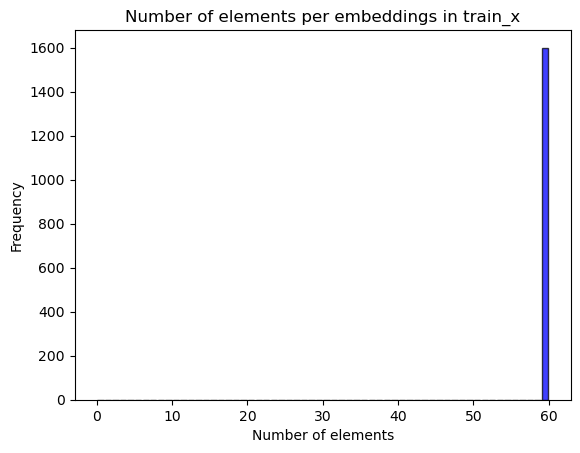

(60, 60, 1600)

In [87]:
#pritn the distribution of the number of elements per embeddings in train_x
elements = [len(feat) for feat in train_x2]
plt.hist(elements, bins=range(0, max(elements)+1, 1), alpha=0.75, rwidth=0.85, color='b', edgecolor='black')
plt.xlabel('Number of elements')
plt.ylabel('Frequency')
plt.title('Number of elements per embeddings in train_x')
plt.show()

#print the min and max number of elements in the embeddings in train_x
min(elements), max(elements), len(elements)

In [36]:
# Flatten node properties into a single list for training
train_node_degrees = np.concatenate([props[0] for props in train_node_properties])
train_clustering_coeffs = np.concatenate([props[1] for props in train_node_properties])
train_betweenness_centralities = np.concatenate([props[2] for props in train_node_properties])

test_node_degrees = np.concatenate([props[0] for props in test_node_properties])
test_clustering_coeffs = np.concatenate([props[1] for props in test_node_properties])
test_betweenness_centralities = np.concatenate([props[2] for props in test_node_properties])

# Convert node properties to PyTorch tensors
train_y_degrees = torch.tensor(train_node_degrees, dtype=torch.float32)
train_y_clustering = torch.tensor(train_clustering_coeffs, dtype=torch.float32)
train_y_betweenness = torch.tensor(train_betweenness_centralities, dtype=torch.float32)

test_y_degrees = torch.tensor(test_node_degrees, dtype=torch.float32)
test_y_clustering = torch.tensor(test_clustering_coeffs, dtype=torch.float32)
test_y_betweenness = torch.tensor(test_betweenness_centralities, dtype=torch.float32)

# Define node properties names and graph properties names
node_properties_names = ['node_degrees', 'clustering_coeffs', 'betweenness_centralities']
embeddings_for_node_properties = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4)]

In [38]:
# Define the node property tensors for training and testing
train_y_list = [train_y_degrees, train_y_clustering, train_y_betweenness]
test_y_list = [test_y_degrees, test_y_clustering, test_y_betweenness]

# Train and evaluate model for node-level properties
for train_embedding, test_embedding in embeddings_for_node_properties:
    input_size = train_embedding.shape[2]  # Since train_embedding is 3D: [num_graphs, num_nodes, embedding_dim]

    for i, property_name in enumerate(node_properties_names):
        model = LinearModel(input_size, output_size=1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 100  # Adjust this as needed

        train_y = train_y_list[i]
        test_y = test_y_list[i]

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            # Flatten the embeddings and the targets to handle as a batch
            train_embedding_flat = train_embedding.view(-1, input_size)
            train_y_flat = train_y.view(-1)

            outputs = model(train_embedding_flat).squeeze()
            target = train_y_flat.squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_embedding_flat = test_embedding.view(-1, input_size)
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y_flat.cpu().numpy()
            test_target = test_y.view(-1).cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Node Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_19056\1345932715.py", line 7, in <module>
    input_size = train_embedding.shape[2]  # Since train_embedding is 3D: [num_graphs, num_nodes, embedding_dim]
IndexError: tuple index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1319, in structured_traceback
    return Verb

In [41]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)


In [42]:
node_properties = ['node_degrees', 'clustering_coeffs', 'betweenness_centralities']
node_y_train = [train_y_degrees, train_y_clustering, train_y_betweenness]
node_y_test = [test_y_degrees, test_y_clustering, test_y_betweenness]

embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4)]
embeddings_names = ['x', 'x2', 'x3', 'x4']

for embedding_name, (train_embedding, test_embedding) in zip(embeddings_names, embeddings):
    input_size = train_embedding.shape[1]

    for property_name, train_y, test_y in zip(node_properties, node_y_train, node_y_test):
        model = LinearModel(input_size, 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 100  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y.squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Embedding: {embedding_name}, Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y.cpu().numpy()
            test_target = test_y.cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {embedding_name}, Node Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_19056\1058151048.py", line 24, in <module>
    loss = criterion(outputs, target)
  File "c:\Users\tomdu\miniconda3\lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "c:\Users\tomdu\miniconda3\lib\site-packages\torch\nn\modules\loss.py", line 536, in forward
    return F.mse_loss(input, target, reduction=self.reduction)
  File "c:\Users\tomdu\miniconda3\lib\site-packages\torch\nn\functional.py", line 3294, in mse_loss
    expanded_input, expanded_target = torch.broadcast_tensors(input, target)
  File "c:\Users\tomdu\miniconda3\lib\site-packages\torch\functional.py", line 74, in broadcast_tensors
    return _VF.broadcast_tensors(tensors)  # type: ignore[attr-defined]
Runti

In [43]:
# Extract node-level embeddings
# This example assumes the node-level embeddings are already extracted
# and the train_node_properties and test_node_properties are computed as before

# Flatten node properties into a single list for training
train_node_degrees = np.concatenate([props[0] for props in train_node_properties])
train_clustering_coeffs = np.concatenate([props[1] for props in train_node_properties])
train_betweenness_centralities = np.concatenate([props[2] for props in train_node_properties])

test_node_degrees = np.concatenate([props[0] for props in test_node_properties])
test_clustering_coeffs = np.concatenate([props[1] for props in test_node_properties])
test_betweenness_centralities = np.concatenate([props[2] for props in test_node_properties])

# Convert node properties to PyTorch tensors
train_y_degrees = torch.tensor(train_node_degrees, dtype=torch.float32)
train_y_clustering = torch.tensor(train_clustering_coeffs, dtype=torch.float32)
train_y_betweenness = torch.tensor(train_betweenness_centralities, dtype=torch.float32)

test_y_degrees = torch.tensor(test_node_degrees, dtype=torch.float32)
test_y_clustering = torch.tensor(test_clustering_coeffs, dtype=torch.float32)
test_y_betweenness = torch.tensor(test_betweenness_centralities, dtype=torch.float32)


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

# Define the linear model for node-level properties
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

node_properties = ['node_degrees', 'clustering_coeffs', 'betweenness_centralities']
node_y_train = [train_y_degrees, train_y_clustering, train_y_betweenness]
node_y_test = [test_y_degrees, test_y_clustering, test_y_betweenness]

embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4)]
embeddings_names = ['x', 'x2', 'x3', 'x4']

for embedding_name, (train_embedding, test_embedding) in zip(embeddings_names, embeddings):
    input_size = train_embedding.shape[1]

    for property_name, train_y, test_y in zip(node_properties, node_y_train, node_y_test):
        model = LinearModel(input_size, 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 100  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y.squeeze()

            # Debugging information
            print(f"Epoch [{epoch+1}/{num_epochs}], Embedding: {embedding_name}, Property: {property_name}")
            print(f"outputs shape: {outputs.shape}, target shape: {target.shape}")

            if outputs.shape != target.shape:
                print(f"Shape mismatch: outputs shape {outputs.shape}, target shape {target.shape}")
                continue

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y.cpu().numpy()
            test_target = test_y.cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {embedding_name}, Node Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')


Epoch [1/100], Embedding: x, Property: node_degrees
outputs shape: torch.Size([1600]), target shape: torch.Size([39060])
Shape mismatch: outputs shape torch.Size([1600]), target shape torch.Size([39060])
Epoch [2/100], Embedding: x, Property: node_degrees
outputs shape: torch.Size([1600]), target shape: torch.Size([39060])
Shape mismatch: outputs shape torch.Size([1600]), target shape torch.Size([39060])
Epoch [3/100], Embedding: x, Property: node_degrees
outputs shape: torch.Size([1600]), target shape: torch.Size([39060])
Shape mismatch: outputs shape torch.Size([1600]), target shape torch.Size([39060])
Epoch [4/100], Embedding: x, Property: node_degrees
outputs shape: torch.Size([1600]), target shape: torch.Size([39060])
Shape mismatch: outputs shape torch.Size([1600]), target shape torch.Size([39060])
Epoch [5/100], Embedding: x, Property: node_degrees
outputs shape: torch.Size([1600]), target shape: torch.Size([39060])
Shape mismatch: outputs shape torch.Size([1600]), target shape 

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_19056\2305052583.py", line 62, in <module>
    train_mse = mean_squared_error(train_target, train_pred)
  File "c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 100, in _check_reg_targets
    check_consistent_length(y_true, y_pred)
  File "c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\utils\validation.py", line 397, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [39060, 1600]

During handling of the above exception, another exception occurred:

Tracebac

In [45]:
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities))
    return properties

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
test_node_properties = compute_node_properties(gnn.dataset[gnn.test_idx])

In [7]:


# Evaluate to get node-level features
train_node_features, test_node_features = gnn.evaluate_with_features()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_18216\1537488665.py", line 2, in <module>
    train_node_features, test_node_features = gnn.evaluate_with_features()
  File "c:\Users\tomdu\miniconda3\lib\site-packages\torch\utils\_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "c:\Users\tomdu\OneDrive\Documents\ENSC_VU\4A-Vu\Thesis\Probing-GNN-representations\models\models_BA_2grid_house.py", line 164, in evaluate_with_features
    graph_node_features = [feat[mask].cpu().numpy() for feat in node_embeddings]
  File "c:\Users\tomdu\OneDrive\Documents\ENSC_VU\4A-Vu\Thesis\Probing-GNN-representations\models\models_BA_2grid_house.py", line 164, in <listcomp>
    graph_node_features = [feat[mask].cpu().numpy() for feat in node_embeddings]
IndexError: The 